
# 📘 Experiment Log : Assignment 1 - softmax.ipynb

- 🗓️ 과제 수행일: 2025.03.28
- ⏱️ 정리일: 2025.03.29
- 🧠 목적: numpy만을 사용하여 softmax의 loss 와 gradient 계산.

---

## 1. 📂 Dataset & Task
- 사용한 데이터셋: CIFAR-10
- Task 유형: 분류
- Input 형태: 이미지(32x32)
- Output 형태: 클래스 라벨

---

## 2. 🧪 실험 내용 요약
- 모델 구조: Softmax Classifier
- Loss 함수: Cross-Entropy
- Optimizer: SGD
- 하이퍼파라미터:
  - learning_rates = [1e-7, 2.5e-7, 5e-7, 7.5e-7, 1e-6, 2.5e-6, 5e-6, 7.5e-6,
   1e-5]
  - regularization_strengths = [1e3, 2.5e3, 5e3, 7.5e3, 1e4]
  - batch size: 500

---

## 3. 📊 실험 결과
- Training Accuracy: 38.9%
- Validation Accuracy: 40.1%
- best learning rate: 7.5e-7
- best regularization: 2.5e3
- Epochs: 10 epochs
- final test set accuracy: 38.6%
---

## 4. 🔍 해석 및 인사이트
- 성능 향상에 효과적이었던 요소: grid search
- 문제점 및 한계: acc = 40% 정도가 한계인 듯함. 더 정교하고 복잡한 모델 사용의 필요성.
- 앞으로 개선할 점: softmax 를 사용하면서도 acc를 더 올리려면 label smoothing 등 활용해보기.

---

## 5. 💬 한 줄 회고
> softmax-with-loss 의 역전파가 y-t 형태라는 것을 사용하니까 gradient를 구하기 편리했다.

---



In [2]:
# This mounts your Google Drive to the Colab VM.
from google.colab import drive
drive.mount('/content/drive')

# TODO: Enter the foldername in your Drive where you have saved the unzipped
# assignment folder, e.g. 'cs231n/assignments/assignment1/'
FOLDERNAME = 'Colab_Notebooks/cs231n/cs231n_assignment1/'

assert FOLDERNAME is not None, "[!] Enter the foldername."

# Now that we've mounted your Drive, this ensures that
# the Python interpreter of the Colab VM can load
# python files from within it.
import sys
sys.path.append('/content/drive/My Drive/{}'.format(FOLDERNAME))

# This downloads the CIFAR-10 dataset to your Drive
# if it doesn't already exist.
%cd /content/drive/My\ Drive/$FOLDERNAME/cs231n/datasets/
!bash get_datasets.sh
%cd /content/drive/My\ Drive/$FOLDERNAME

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/My Drive/Colab_Notebooks/cs231n/cs231n_assignment1/cs231n/datasets
/content/drive/My Drive/Colab_Notebooks/cs231n/cs231n_assignment1


# Softmax exercise

*Complete and hand in this completed worksheet (including its outputs and any supporting code outside of the worksheet) with your assignment submission. For more details see the [assignments page](http://vision.stanford.edu/teaching/cs231n/assignments.html) on the course website.*

This exercise is analogous to the SVM exercise. You will:

- implement a fully-vectorized **loss function** for the Softmax classifier
- implement the fully-vectorized expression for its **analytic gradient**
- **check your implementation** with numerical gradient
- use a validation set to **tune the learning rate and regularization** strength
- **optimize** the loss function with **SGD**
- **visualize** the final learned weights


In [3]:
import random
import numpy as np
from cs231n.data_utils import load_CIFAR10
import matplotlib.pyplot as plt

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading extenrnal modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

In [4]:
def get_CIFAR10_data(num_training=49000, num_validation=1000, num_test=1000, num_dev=500):
    """
    Load the CIFAR-10 dataset from disk and perform preprocessing to prepare
    it for the linear classifier. These are the same steps as we used for the
    SVM, but condensed to a single function.
    """
    # Load the raw CIFAR-10 data
    cifar10_dir = 'cs231n/datasets/cifar-10-batches-py'

    # Cleaning up variables to prevent loading data multiple times (which may cause memory issue)
    try:
       del X_train, y_train
       del X_test, y_test
       print('Clear previously loaded data.')
    except:
       pass

    X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)

    # subsample the data
    mask = list(range(num_training, num_training + num_validation))
    X_val = X_train[mask]
    y_val = y_train[mask]
    mask = list(range(num_training))
    X_train = X_train[mask]
    y_train = y_train[mask]
    mask = list(range(num_test))
    X_test = X_test[mask]
    y_test = y_test[mask]
    mask = np.random.choice(num_training, num_dev, replace=False)
    X_dev = X_train[mask]
    y_dev = y_train[mask]

    # Preprocessing: reshape the image data into rows
    X_train = np.reshape(X_train, (X_train.shape[0], -1))
    X_val = np.reshape(X_val, (X_val.shape[0], -1))
    X_test = np.reshape(X_test, (X_test.shape[0], -1))
    X_dev = np.reshape(X_dev, (X_dev.shape[0], -1))

    # Normalize the data: subtract the mean image
    mean_image = np.mean(X_train, axis = 0)
    X_train -= mean_image
    X_val -= mean_image
    X_test -= mean_image
    X_dev -= mean_image

    # add bias dimension and transform into columns
    X_train = np.hstack([X_train, np.ones((X_train.shape[0], 1))])
    X_val = np.hstack([X_val, np.ones((X_val.shape[0], 1))])
    X_test = np.hstack([X_test, np.ones((X_test.shape[0], 1))])
    X_dev = np.hstack([X_dev, np.ones((X_dev.shape[0], 1))])

    return X_train, y_train, X_val, y_val, X_test, y_test, X_dev, y_dev


# Invoke the above function to get our data.
X_train, y_train, X_val, y_val, X_test, y_test, X_dev, y_dev = get_CIFAR10_data()
print('Train data shape: ', X_train.shape)
print('Train labels shape: ', y_train.shape)
print('Validation data shape: ', X_val.shape)
print('Validation labels shape: ', y_val.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)
print('dev data shape: ', X_dev.shape)
print('dev labels shape: ', y_dev.shape)

Train data shape:  (49000, 3073)
Train labels shape:  (49000,)
Validation data shape:  (1000, 3073)
Validation labels shape:  (1000,)
Test data shape:  (1000, 3073)
Test labels shape:  (1000,)
dev data shape:  (500, 3073)
dev labels shape:  (500,)


## Softmax Classifier

Your code for this section will all be written inside `cs231n/classifiers/softmax.py`.


In [5]:
# First implement the naive softmax loss function with nested loops.
# Open the file cs231n/classifiers/softmax.py and implement the
# softmax_loss_naive function.

from cs231n.classifiers.softmax import softmax_loss_naive
import time

# Generate a random softmax weight matrix and use it to compute the loss.
W = np.random.randn(3073, 10) * 0.0001
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 0.0)

# As a rough sanity check, our loss should be something close to -log(0.1).
print('loss: %f' % loss)
print('sanity check: %f' % (-np.log(0.1)))

loss: 2.368991
sanity check: 2.302585


**Inline Question 1**

Why do we expect our loss to be close to -log(0.1)? Explain briefly.**

$\color{blue}{\textit Your Answer:}$ *학습을 진행하지 않고 무작위로 설정된 가중치를 곱했으므로 각 class별 점수가 거의 비슷하다고 가정. 전체 class의 개수가 10개이므로 exponential 후 전체에서의 비율을 구하면 대략 0.1이 나온다.*



In [6]:
# Complete the implementation of softmax_loss_naive and implement a (naive)
# version of the gradient that uses nested loops.
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 0.0)

# As we did for the SVM, use numeric gradient checking as a debugging tool.
# The numeric gradient should be close to the analytic gradient.
from cs231n.gradient_check import grad_check_sparse
f = lambda w: softmax_loss_naive(w, X_dev, y_dev, 0.0)[0]
grad_numerical = grad_check_sparse(f, W, grad, 10)

# similar to SVM case, do another gradient check with regularization
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 5e1)
f = lambda w: softmax_loss_naive(w, X_dev, y_dev, 5e1)[0]
grad_numerical = grad_check_sparse(f, W, grad, 10)

numerical: 1.626376 analytic: 1.626376, relative error: 8.796555e-09
numerical: -0.097116 analytic: -0.097116, relative error: 5.062908e-08
numerical: 1.048634 analytic: 1.048634, relative error: 8.874732e-09
numerical: -1.474870 analytic: -1.474870, relative error: 4.056983e-08
numerical: -0.644111 analytic: -0.644111, relative error: 6.154086e-08
numerical: 0.402807 analytic: 0.402807, relative error: 1.149533e-07
numerical: 3.163381 analytic: 3.163381, relative error: 1.518133e-08
numerical: -0.751454 analytic: -0.751454, relative error: 4.280631e-08
numerical: -2.039147 analytic: -2.039147, relative error: 2.527028e-09
numerical: 0.579087 analytic: 0.579087, relative error: 9.604595e-08
numerical: -2.863027 analytic: -2.863028, relative error: 1.327841e-08
numerical: -6.759917 analytic: -6.759917, relative error: 5.217641e-09
numerical: 0.875543 analytic: 0.875543, relative error: 3.433116e-08
numerical: -0.562330 analytic: -0.562330, relative error: 3.536962e-08
numerical: 0.15553

In [7]:
# Now that we have a naive implementation of the softmax loss function and its gradient,
# implement a vectorized version in softmax_loss_vectorized.
# The two versions should compute the same results, but the vectorized version should be
# much faster.
tic = time.time()
loss_naive, grad_naive = softmax_loss_naive(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('naive loss: %e computed in %fs' % (loss_naive, toc - tic))

from cs231n.classifiers.softmax import softmax_loss_vectorized
tic = time.time()
loss_vectorized, grad_vectorized = softmax_loss_vectorized(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('vectorized loss: %e computed in %fs' % (loss_vectorized, toc - tic))

# As we did for the SVM, we use the Frobenius norm to compare the two versions
# of the gradient.
grad_difference = np.linalg.norm(grad_naive - grad_vectorized, ord='fro')
print('Loss difference: %f' % np.abs(loss_naive - loss_vectorized))
print('Gradient difference: %f' % grad_difference)

naive loss: 2.368991e+00 computed in 0.073559s
vectorized loss: 2.368991e+00 computed in 0.022700s
Loss difference: 0.000000
Gradient difference: 0.000000


In [8]:
# Use the validation set to tune hyperparameters (regularization strength and
# learning rate). You should experiment with different ranges for the learning
# rates and regularization strengths; if you are careful you should be able to
# get a classification accuracy of over 0.35 on the validation set.
import copy

from cs231n.classifiers import Softmax
results = {}
best_val = -1
best_softmax = None

################################################################################
# TODO:                                                                        #
# Use the validation set to set the learning rate and regularization strength. #
# This should be identical to the validation that you did for the SVM; save    #
# the best trained softmax classifer in best_softmax.                          #
################################################################################

# Provided as a reference. You may or may not want to change these hyperparameters
learning_rates = [1e-7, 2.5e-7, 5e-7, 7.5e-7, 1e-6, 2.5e-6, 5e-6, 7.5e-6, 1e-5]
regularization_strengths = [1e3, 2.5e3, 5e3, 7.5e3, 1e4]


# *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

count = 0
for lr in learning_rates:
    for reg in regularization_strengths:
        val_softmax = Softmax()
        val_softmax.train(X_train, y_train, learning_rate = lr,
                          reg = reg, num_iters = 1000, batch_size = 500, verbose = True)
        train_accuracy = np.mean(y_train == val_softmax.predict(X_train))
        val_accuracy = np.mean(y_val == val_softmax.predict(X_val))
        results[(lr,reg)] = (train_accuracy, val_accuracy)
        if (val_accuracy > best_val):
            best_val = val_accuracy
            best_softmax = copy.deepcopy(val_softmax) ## 혹시나 해서 deepcopy를 썼는데 안 써도 괜찮다는 것을 알아냄. 25.03.29.
        count += 1
        print(f"{count}/{len(learning_rates) * len(regularization_strengths)}")


# *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

# Print out results.
results = dict(sorted(results.items(), key=lambda x: x[1][1], reverse=True))
for lr, reg in results:
    train_accuracy, val_accuracy = results[(lr, reg)]
    print('lr %e reg %e train accuracy: %f val accuracy: %f' % (
                lr, reg, train_accuracy, val_accuracy))

print('best validation accuracy achieved during cross-validation: %f' % best_val)

iteration 0 / 1000: loss 36.154497
iteration 100 / 1000: loss 32.822389
iteration 200 / 1000: loss 31.384314
iteration 300 / 1000: loss 29.767635
iteration 400 / 1000: loss 28.357674
iteration 500 / 1000: loss 27.181085
iteration 600 / 1000: loss 26.279093
iteration 700 / 1000: loss 25.247670
iteration 800 / 1000: loss 24.232448
iteration 900 / 1000: loss 23.112650
1/45
iteration 0 / 1000: loss 82.814607
iteration 100 / 1000: loss 73.698896
iteration 200 / 1000: loss 66.294081
iteration 300 / 1000: loss 59.767644
iteration 400 / 1000: loss 54.293927
iteration 500 / 1000: loss 49.136880
iteration 600 / 1000: loss 44.471076
iteration 700 / 1000: loss 40.183695
iteration 800 / 1000: loss 36.625088
iteration 900 / 1000: loss 33.142241
2/45
iteration 0 / 1000: loss 159.554564
iteration 100 / 1000: loss 129.583154
iteration 200 / 1000: loss 105.935043
iteration 300 / 1000: loss 86.938059
iteration 400 / 1000: loss 71.397516
iteration 500 / 1000: loss 58.479297
iteration 600 / 1000: loss 48.1

In [9]:
# evaluate on test set
# Evaluate the best softmax on test set
y_test_pred = best_softmax.predict(X_test)
test_accuracy = np.mean(y_test == y_test_pred)
print('softmax on raw pixels final test set accuracy: %f' % (test_accuracy, ))

softmax on raw pixels final test set accuracy: 0.386000


**Inline Question 2** - *True or False*

Suppose the overall training loss is defined as the sum of the per-datapoint loss over all training examples. It is possible to add a new datapoint to a training set that would leave the SVM loss unchanged, but this is not the case with the Softmax classifier loss.

$\color{blue}{\textit Your Answer:}$ True


$\color{blue}{\textit Your Explanation:}$ SVM loss 한 데이터에 대한 loss 가 0으로 나올 수 있다. 하지만 softmax classifier 에서는 loss가 로그의 형태로 나타난다. 즉, loss가 0이 되기 위해서는 log 안의 값이 0이 되어야 하는데, log 안의 값이 0이 되기 위해서는 정답 레이블 이외 class 들에 대한 score들이 exp(score) = 0을 만족해야 한다. 그러나 이것을 만족하는 score가 없기 때문에 loss가 0이 될 수 없다.



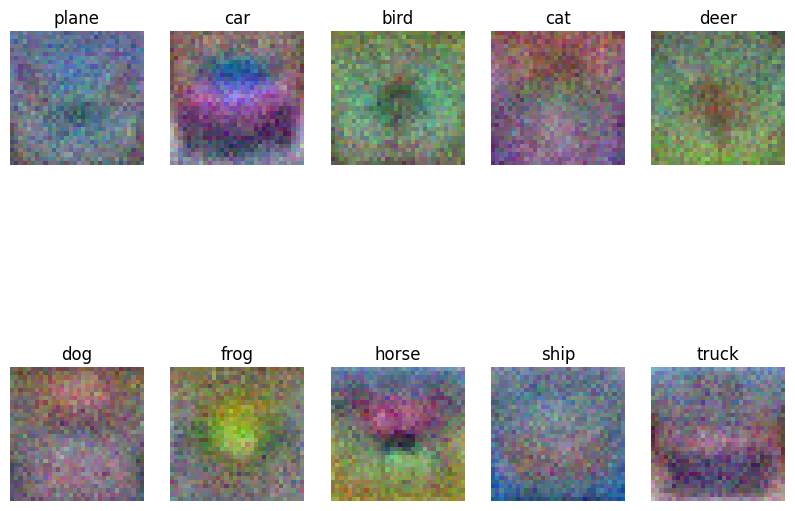

In [10]:
# Visualize the learned weights for each class
w = best_softmax.W[:-1,:] # strip out the bias
w = w.reshape(32, 32, 3, 10)

w_min, w_max = np.min(w), np.max(w)

classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for i in range(10):
    plt.subplot(2, 5, i + 1)

    # Rescale the weights to be between 0 and 255
    wimg = 255.0 * (w[:, :, :, i].squeeze() - w_min) / (w_max - w_min)
    plt.imshow(wimg.astype('uint8'))
    plt.axis('off')
    plt.title(classes[i])